## This notebook builds a gradio app which enhances image. Enhances brightness, shadows, darks, and midtones.

In [ ]:
!pip install --upgrade gradio

# Tone adjustment functions

## Midtones adjustment

In [ ]:
import numpy as np
def adjust_midtones_v3(image, value):
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
  L, A, B = cv2.split(lab)

  delta_L = 0.6 * value * np.exp(-((L - 129.8)**2) / (2 * 42.3**2))
  #apply adjustment
  L_adjusted = np.clip(L + delta_L, 0, 255).astype(np.uint8)

  #merge and convert back to RGB
  lab_adjusted = cv2.merge((L_adjusted, A, B))
  adjusted_image = cv2.cvtColor(lab_adjusted, cv2.COLOR_Lab2BGR)
  return adjusted_image

## Blacks adjustment

In [ ]:
def adjust_blacks_v2(image, value, mu=0, sigma=180):#60


    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    L, A, B = cv2.split(lab)


    L_norm = L / 255.0
    value = value / 50.0  # Normalize value to range [-1, 1]

    gaussian_delta = value * np.exp(-((L_norm - mu) ** 2) / (2 * (sigma / 255.0) ** 2))

    scaled_delta = gaussian_delta * (L_norm) * (1 - L_norm)

    L_adjusted = np.clip(L_norm + scaled_delta, 0, 1) * 255
    L_adjusted = L_adjusted.astype(np.uint8)


    lab_adjusted = cv2.merge((L_adjusted, A, B))
    adjusted_image = cv2.cvtColor(lab_adjusted, cv2.COLOR_Lab2BGR)

    return adjusted_image

In [ ]:
def adjust_blacks_v3(image, value, mu=0, sigma=180):#60
    """
    Adjust the blacks in an image by modifying the V channel of hsv by using gaussian function
    """
    #convert image to Lab color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    A, B, L = cv2.split(lab)

    L_norm = L / 255.0
    value = value / 60.0

    gaussian_delta = value * np.exp(-((L_norm - mu) ** 2) / (2 * (sigma / 255.0) ** 2))

    scaled_delta = gaussian_delta * (L_norm) * (1 - L_norm)

    L_adjusted = np.clip(L_norm + scaled_delta, 0, 1) * 255
    L_adjusted = L_adjusted.astype(np.uint8)


    lab_adjusted = cv2.merge(( A, B, L_adjusted,))
    adjusted_image = cv2.cvtColor(lab_adjusted, cv2.COLOR_HSV2BGR)

    return adjusted_image

## Shadow adjustment no color shift

In [ ]:
import cv2
import numpy as np

def adjust_shadows_smooth(image, value):
    # Convert the image to Lab color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    L, A, B = cv2.split(lab)

    # Reg functions coefs
    a = 1.3961732711564908e-06
    b = 0.0008895951539483089
    c = 0.5240989144677771
    d = 0.0010981967922047975
    e = 0.7139417752580282
    k = 0.0008380261684808046
    i = -7.52806683805607e-06
    j = -1.5172768858204137e-05
    f_const = 14.27484893064689

    def f_func_vectorized(g, s):
        return (a * g**3 +
                b * g**2 +
                c * g +
                d * s**2 +
                e * s +
                k * g * s +
                i * g**2 * s +
                j * s**2 * g +
                f_const)

    L_float = L.astype(np.float64)
    mask = (L_float > 0) & (L_float < 255)
    L_new = np.where(mask, f_func_vectorized(value, L_float), L_float)
    L_new = np.clip(L_new, 0, 255).astype(np.uint8)
    adjusted_lab = cv2.merge((L_new, A, B))
    adjusted_image = cv2.cvtColor(adjusted_lab, cv2.COLOR_Lab2BGR)

    return adjusted_image


## Shadow adjustment colorshift

In [ ]:
import cv2
import numpy as np

a = 1.3961732711564908e-06
b = 0.0008895951539483089
c = 0.5240989144677771
d = 0.0010981967922047975
e = 0.7139417752580282
k = 0.0008380261684808046
i = -7.52806683805607e-06
j = -1.5172768858204137e-05
f_const = 14.27484893064689

def f_func_vectorized(g, s):
    return (a * g**3 +
            b * g**2 +
            c * g +
            d * s**2 +
            e * s +
            k * g * s +
            i * g**2 * s +
            j * s**2 * g +
            f_const)

def adjust_shadows_smooth_rgb(image, value):
    image_float = image.astype(np.float64)

    B, G, R = cv2.split(image_float)

    # Calculate luminance Y using Rec.709
    Y = 0.2126 * R + 0.7152 * G + 0.0722 * B
    Y_prime = f_func_vectorized(value, Y)

    # Avoid division by zero by setting minimum Y to a small value
    Y_safe = np.where(Y == 0, 1e-6, Y)

    # Compute the scaling factor
    scale = Y_prime / Y_safe

    # limit the scaling factor to prevent extreme changes
    scale = np.clip(scale, 0, 3)
    R_new = R * scale
    G_new = G * scale
    B_new = B * scale

    # clip the RGB values to [0, 255]
    R_new = np.clip(R_new, 0, 255)
    G_new = np.clip(G_new, 0, 255)
    B_new = np.clip(B_new, 0, 255)

    adjusted_image_float = cv2.merge([B_new, G_new, R_new])
    adjusted_image = adjusted_image_float.astype(np.uint8)

    return adjusted_image

## Highlights adjustments

In [ ]:
import cv2
import numpy as np

def adjust_highlights_smooth_2(image, value):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    L, A, B = cv2.split(lab)
    a = 4.2492229988965675e-07
    b = 0.0011647464923216252
    c = -0.30823090606037157
    d = -0.0012365789289133788
    e = 1.3200344809468931
    k = 0.007789091419737289
    i = -8.091018482820888e-06
    j = -1.6849049899651455e-05
    f_const = -16.012025253364175

    def f_func_vectorized(g, s):
        return (a * g**3 +
                b * g**2 +
                c * g +
                d * s**2 +
                e * s +
                k * g * s +
                i * g**2 * s +
                j * s**2 * g +
                f_const)

    L_float = L.astype(np.float64)
    mask = (L_float > 0) & (L_float < 255)
    L_new = np.where(mask, f_func_vectorized(value, L_float), L_float)
    L_new = np.clip(L_new, 0, 255).astype(np.uint8)
    adjusted_lab = cv2.merge((L_new, A, B))
    adjusted_image = cv2.cvtColor(adjusted_lab, cv2.COLOR_Lab2BGR)

    return adjusted_image


# Gradio

In [ ]:
import gradio as gr
def process_image(image, adjustment_type, value):
    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    if adjustment_type == "Highlights":
        result = adjust_highlights_smooth_2(image, value)
    elif adjustment_type == "Midtones":
        result = adjust_midtones_v3(image, value)
    elif adjustment_type == "Shadows no color shift":
        result = adjust_shadows_smooth(image, value)
    elif adjustment_type == "Shadows color shift":
        result = adjust_shadows_smooth_rgb(image, value)
    elif adjustment_type == "Blacks_v":
        result = adjust_blacks_v3(image, value, mu=0, sigma=180)
    elif adjustment_type == "Blacks_l":
        result = adjust_blacks_v2(image, value, mu=0, sigma=180)
    else:
        result = image

    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

with gr.Blocks() as demo:
    gr.Markdown("# Image Adjustment Tool")
    gr.Markdown("Upload a photo, choose an adjustment type, and adjust the slider to modify the highlights or midtones.")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Image")
            adjustment_type = gr.Dropdown(choices=["Highlights", "Midtones", "Shadows no color shift","Shadows color shift", "Blacks_v", "Blacks_l"], label="Adjustment Type")
            adjustment_slider = gr.Slider(-100, 100, step=1, label="Adjustment Value")
            process_button = gr.Button("Apply Adjustment")

        with gr.Column():
            image_output = gr.Image(type="pil", label="Adjusted Image")

    process_button.click(process_image, inputs=[image_input, adjustment_type, adjustment_slider], outputs=image_output)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2fc2f6312fc6812121.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Gradio with histogram

In [ ]:
import gradio as gr
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def compute_histogram(image, save_path):
    """Compute and save the histogram plot as an image."""
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    channels = ['Blue', 'Green', 'Red']
    colors = ['blue', 'green', 'red']

    plt.figure(figsize=(6, 4))
    plt.title("Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.ylim(0, 0.02*image.shape[0]*image.shape[1])
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(np.convolve(hist[:, 0], [0.33, 0.33, 0.33]), color=color, label=f'{channels[i]}')
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l_channel = image_lab[:, :, 0]
    hist_luminance = cv2.calcHist([l_channel], [0], None, [256], [0, 256])
    plt.plot(np.convolve(hist_luminance[:, 0], [0.33, 0.33, 0.33]), color='black', label='Luminance (CIELAB)')

    plt.legend()
    plt.grid(True)

    # Save the plot to the specified path
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def process_image(image, adjustment_type, value):
    """Process the image based on the adjustment type and value."""
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    if adjustment_type == "Highlights":
        result = adjust_highlights_smooth_2(image, value)
    elif adjustment_type == "Midtones":
        result = adjust_midtones_v3(image, value)
    elif adjustment_type == "Shadows no color shift":
        result = adjust_shadows_smooth(image, value)
    elif adjustment_type == "Shadows color shift":
        result = adjust_shadows_smooth_rgb(image, value)
    elif adjustment_type == "Blacks_v":
        result = adjust_blacks_v3(image, value, mu=0, sigma=180)
    elif adjustment_type == "Blacks_l":
        result = adjust_blacks_v2(image, value, mu=0, sigma=180)
    else:
        result = image
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    result = Image.fromarray(result)

    # Save histograms for original and adjusted images
    original_hist_path = "original_histogram.png"
    adjusted_hist_path = "adjusted_histogram.png"
    compute_histogram(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), original_hist_path)
    compute_histogram(result, adjusted_hist_path)

    return result, original_hist_path, adjusted_hist_path

with gr.Blocks() as demo:
    gr.Markdown("# Image Adjustment Tool")
    gr.Markdown("Upload a photo, choose an adjustment type, and adjust the slider to modify the highlights, midtones, shadows, or blacks.")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Image")
            input_histogram = gr.Image(type="filepath", label="Original Image Histogram")
            adjustment_type = gr.Dropdown(choices=["Highlights", "Midtones", "Shadows no color shift","Shadows color shift", "Blacks_v", "Blacks_l"],
                                          label="Adjustment Type")
            adjustment_slider = gr.Slider(-100, 100, step=1, label="Adjustment Value")
            process_button = gr.Button("Apply Adjustment")
        with gr.Column():
            image_output = gr.Image(type="pil", label="Adjusted Image")
            output_histogram = gr.Image(type="filepath", label="Adjusted Image Histogram")

    process_button.click(process_image,
                         inputs=[image_input, adjustment_type, adjustment_slider],
                         outputs=[image_output, input_histogram, output_histogram])

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bca26e923dc5a236f7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# miscellineous and utils down here

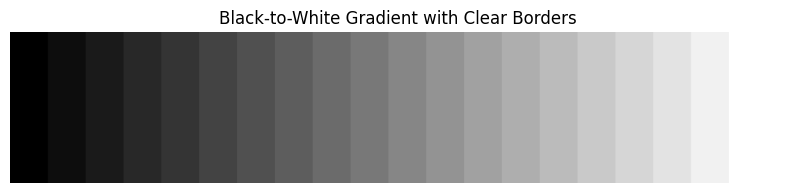

True

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_black_white_gradient(width=2048, height=1024, num_shades=20):
    gradient = np.zeros((height, width), dtype=np.uint8)


    step = width // num_shades


    for i in range(num_shades):
        shade_value = int((i / (num_shades - 1)) * 255)
        gradient[:, i * step:(i + 1) * step] = shade_value


    gradient[:, num_shades * step:] = 255

    return gradient


gradient_image = create_black_white_gradient(width=512, height=100, num_shades=20)


plt.figure(figsize=(10, 2))
plt.title("Black-to-White Gradient with Clear Borders")
plt.imshow(gradient_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()


cv2.imwrite("black_white_gradient.jpg", gradient_image)


In [ ]:
#create a gradient test image
gradient_image = create_black_white_gradient(width=2048, height=1024, num_shades=40)

#rgb to gray
gradient_rgb = cv2.cvtColor(gradient_image, cv2.COLOR_GRAY2BGR)

cv2.imwrite("grad_40.jpg", gradient_rgb, [cv2.IMWRITE_JPEG_QUALITY, 200])
print("Gradient saved as 'grad_40.jpg'")

Gradient saved as 'grad_40.jpg'


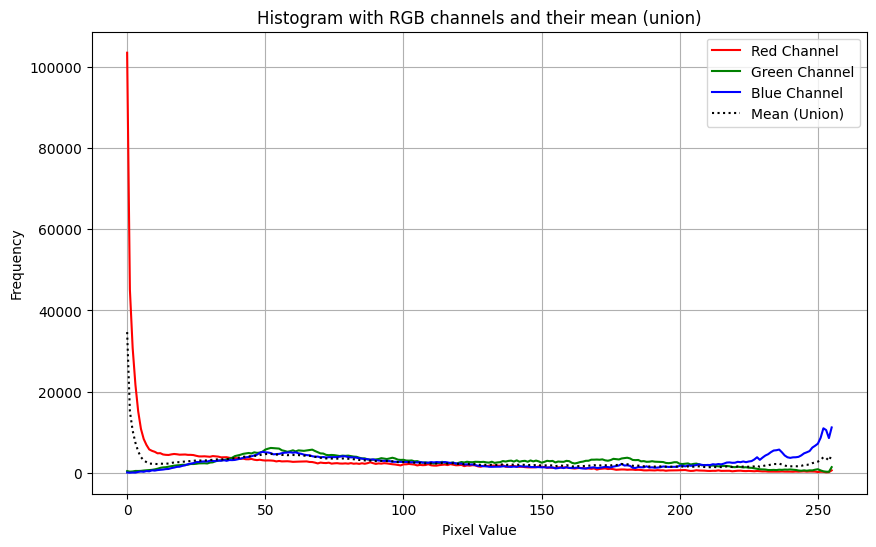

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def plot_histogram_with_mean(image_rgb):
    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(10, 6))
    plt.title("Histogram with RGB channels and their mean (union)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    histograms = []
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f'{channels[i]} Channel')
        histograms.append(hist)
    mean_histogram = np.mean(histograms, axis=0)
    plt.plot(mean_histogram, color='black', label='Mean (Union)', linestyle='dotted')

    plt.legend()
    plt.grid(True)
    plt.show()


image_path = 'img.jpg'
image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_histogram_with_mean(image_rgb)



In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def plot_histogram_with_mean(image_rgb):
    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(10, 6))
    plt.title("Histogram with RGB channels and their mean (union)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    histograms = []
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f'{channels[i]} Channel')
        histograms.append(hist)

    mean_histogram = np.mean(histograms, axis=0)
    plt.plot(mean_histogram, color='black', label='Mean (Union)', linestyle='dotted')

    plt.legend()
    plt.grid(True)
    plt.show()


image_path = '/mnt/data/image.png'
image = cv2.imread(image_path)

if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plot_histogram_with_mean(image_rgb)
else:
    print("Error: Could not load the image.")


In [ ]:
import gradio as gr
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def compute_histogram(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    channels = ['Red', 'Green', 'Blue']
    colors = ['red', 'green', 'blue']

    plt.figure(figsize=(6, 4))
    plt.title("Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f'{channels[i]}')

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt_image = Image.fromarray(np.uint8(plt.imread(plt.gcf().canvas.tostring_rgb())))
    plt.close()
    return plt_image

def process_image(image, adjustment_type, value):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    if adjustment_type == "Highlights":
        result = adjust_highlights_smooth(image, value)  # Adjust highlights
    elif adjustment_type == "Midtones":
        result = adjust_midtones_smooth(image, value)  # Adjust midtones
    elif adjustment_type == "Shadows":
        result = adjust_shadows_smooth(image, value)  # Adjust shadows
    elif adjustment_type == "Blacks":
        result = adjust_blacks_v2(image, value)  # Adjust blacks
    else:
        result = image  # No adjustment

    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    result = Image.fromarray(result)

    original_histogram = compute_histogram(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
    adjusted_histogram = compute_histogram(result)

    return result, original_histogram, adjusted_histogram


with gr.Blocks() as demo:
    gr.Markdown("# Image Adjustment Tool")
    gr.Markdown("Upload a photo, choose an adjustment type, and adjust the slider to modify the highlights, midtones, shadows, or blacks.")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Image")
            adjustment_type = gr.Dropdown(choices=["Highlights", "Midtones", "Shadows", "Blacks"], label="Adjustment Type")
            adjustment_slider = gr.Slider(-100, 100, step=1, label="Adjustment Value")
            process_button = gr.Button("Apply Adjustment")

        with gr.Column():
            image_output = gr.Image(type="pil", label="Adjusted Image")
            input_histogram = gr.Image(type="pil", label="Original Image Histogram")
            output_histogram = gr.Image(type="pil", label="Adjusted Image Histogram")

    process_button.click(process_image,
                         inputs=[image_input, adjustment_type, adjustment_slider],
                         outputs=[image_output, input_histogram, output_histogram])

# Launch the app
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://be2d4a8be03f32dc33.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


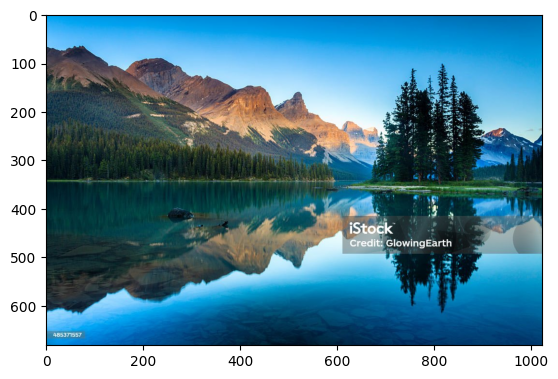

In [ ]:
plt.imshow(image_rgb)